# Descrição

Esse notebook apresenta um detector de gênero em áudios em português, o objetivo é aplicar em ligações comerciais para determinar o gênero do cliente. Para geração de um dataset foram utilizadas duas bases:

[Spoken Portuguese - Geographical and Social Varieties](http://www.clul.ulisboa.pt/en/10-research/737-spoken-portuguese-geographical-and-social-varieties)

[VoxForge](http://www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/)

Em ambas bases já está mapeado o gênero do falante, como o objetivo desse detector é determinar o gênero do cliente em ligações comerciais os audios das bases foram convertidos para ficar com mesmo sample rate(800Hz) das ligações que é o padrão dos audios de ligações que o modelo será testado. Alem disso os áudios foram convertidos de stéreo para mono pois a biblioteca de extrações trabalha apenas com áudios mono.


# Imports e defines

In [52]:
#!/usr/bin/env python

"""pyAudioAnalysis imports"""
import sys
old_stdout = sys.stdout
sys.stdout = open('stdout.txt', 'w')
from pyAudioAnalysis.audioSegmentation import silenceRemoval
from pyAudioAnalysis.audioBasicIO import readAudioFile
from pyAudioAnalysis.audioBasicIO import stereo2mono
from pyAudioAnalysis.audioFeatureExtraction import mtFeatureExtraction
from pyAudioAnalysis.audioFeatureExtraction import stFeatureExtraction
sys.stdout = old_stdout

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

import matplotlib.pyplot as plt

import librosa
import pandas as pd
import numpy as np
import os
import json

import silenceDetector


import seaborn as sns

sns.set(style='whitegrid', context='notebook')
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn-whitegrid')

chunkSize_sec = 20

# Obtendo dados

Baixando toda a base [VoxForge.](http://www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/)


In [2]:
%%bash

#Checking if the audios folders exists
if [ ! -d "audios" ]; then
  mkdir audios
fi
cd "audios"

#Downloading every audio folder on:
# http://www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/
wget -A tgz -m -p -E -k -K -np http://www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/
cd www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/

mv * ../../../../../../..
cd ../../../../../../..
rm -rf "www.repository.voxforge1.org"


#Extracting all the data
find -name "*.tgz" -exec tar xzf '{}' \;

rm -r *.tgz
rm LICENSE
rm -rf wav
rm -rf etc

Baixando toda a base [Spoken Portuguese - Geographical and Social Varieties.](http://www.clul.ulisboa.pt/en/10-research/737-spoken-portuguese-geographical-and-social-varieties)

In [3]:
%%bash

#Checking if the audios folders exists
if [ ! -d "audios" ]; then
  mkdir audios
fi
cd "audios"

wget http://www.clul.ulisboa.pt/sectores/linguistica_de_corpus/Portugues_Falado/Brasil.zip
unzip Brasil.zip
rm Brasil.zip

Process is interrupted.


# Preparando dados

In [2]:
def featureExtratorPyAudioAnalysisMedium(x, mwSize, msSize, swSize, ssSize):
    """Extract feature from audios, the full list of features and the description of them can be founded on:
    https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction
    
    Args:
        X: Audio path
        
        mwSize: wm stands to medium window, 
                this parameter defines the size of the window to the medium window on feature extraction.
                
        msSize: ms stands to medium step,
                this parameter defines the size of the window to the medium step on feature extraction.
        
        swSize: sw stands to small window,
                this parameter defines the size of the window to the small window on feature extraction.
                
         ssSize: ss stands to small step,
                this parameter defines the size of the window to the small step on feature extraction.
                
    Example of use:
    
        dfMedium = featureExtratorPyAudioAnalysisMedium('exemplo1.wav', 2, 1,.1, .05)
    
    Returns:
        
        A pandas dataframe with the features of the audio
    """
    #Opening the audio
    Fs, audio = readAudioFile(x)

    [mean, st, f_names] = mtFeatureExtraction(audio, Fs, mwSize*Fs, msSize*Fs, swSize*Fs, ssSize*Fs)

    #Calculating audio duration in seconds
    audioSize = len(audio)/Fs + 1

    audioFeatures = []
    numLines = audioSize/msSize

    #Only classified lines are important
    for index in range(0,int(numLines)):
        line = []
        initialTimeStamp = index*msSize

        line.append(initialTimeStamp)
        audioFeatures.append(line)

    for feature in mean:
        for featureWindow in range(0,int(numLines)):
            try:
                audioFeatures[featureWindow].append(feature[featureWindow])
            except Exception as e:
                break

    columns = []
    columns.append("Start time")
    for i in range(0, len(f_names)):
        columns.append(f_names[i])
    return pd.DataFrame(audioFeatures, columns=columns)


def joinMinIntervals(intervals, minInterval):
    """Gets a group of intervals like:
        [[0,2],[3,4],[4,5]]
        And a minInterval if the distance between two intervals theese two intervals are merged
    
    Args:
        intervals:  a group of intervals
        
        minInterval: a number to the Minimum distance between two intervals
                
    Example of use:
    
        joinMinIntervals([[0,2.3],[2.5,3],[5,6]], 0.4) =Returns=> [[0,3],[5,6]]
    
    Returns:
        An array with the new intervals.
        
    """
    
    intervalResults = []
    startTime = 0
    for i in range(0,len(intervals)-1):
        if intervals[i+1][0] - intervals[i][1]  > minInterval:
            intervalResults.append([startTime, intervals[i][1]])
            startTime = intervals[i+1][0]
    return intervalResults


def getAvaiableIntervals(intervals, audioDuration, intervalSize):
    """Gets a group of intervals like:
        [[0,2],[3,4],[4,5]]
        and intervalSize the minimum size of an interval, and returns all the empty
        intervals in this group.
    
    Args:
        intervals:  a group of intervals
        
        audioDuration: a number the specifies the size of the processed audio
        
        intervalSize: a number to the Minimum size of an intervals
    
    Returns:
        An array with the avaiable intervals.
        
    """
    intervalResults = []
    startTime = 0

    for i in range(0, audioDuration, intervalSize):
        avaiable = True
        for interval in intervals:
            if interval[0] <= i and (i + intervalSize) <= interval[1]:
                avaiable = False
                break
        if(avaiable):
            intervalResults.append([i, i+intervalSize])
    return intervalResults


def complementArray(originalArray, audioDuration, minSize=0):
    """Gets a group of intervals like:
        [[0,2],[3,4],[4,5]]
        and returns the complement of this intervals, on the example:
        [[2,3]].
    
    Args:
        originalArray:  a group of intervals
        
        audioDuration: a number the specifies the size of the processed audio
        
        minSize: a number to the Minimum size of an intervals
    
    Returns:
        The complement array of originalArray.
        
    """
    newArray = []
    startTime = 0
    endTime = 0
    for interval in originalArray:
        endTime = interval[0]
        if(endTime - startTime > minSize):
            newArray.append([startTime, endTime])
        startTime = interval[1]
    return newArray


def getInterval(dfResults, intervalId):
    """Gets a pandas dataFrame with result and 'Start time 'columns
    and returns all the intervals that the result is equals to intervalId.
    
    Args:
        dfResults:  a pandas dataFrame with the results
        
        intervalId: a number/the searched result
    
    Returns:
        The complement array of originalArray.
        
    """
    
    startInterval = 0

    intervals = []
    for index, row in dfResults.iterrows():
        if(row['result'] != intervalId):
            if(startInterval != row['Start time']):
                endInterval = row['Start time']
                intervals.append([startInterval,endInterval])
                startInterval = row['Start time']+1
            else:
                startInterval = row['Start time']+1
    return intervals


In [89]:
%%bash

#Checking if the audios folders exists
if [ ! -d "features" ]; then
  mkdir features
fi
cd "features"


if [ ! -d "withHeaders" ]; then
  mkdir withHeaders
fi
if [ ! -d "noHeaders" ]; then
  mkdir noHeaders
fi

Extraindo as features da base [VoxForge](http://www.repository.voxforge1.org/downloads/pt/Trunk/Audio/Main/8kHz_16bit/)

In [90]:


filesList = os.listdir("./audios/")
total = len( filesList)
atual = 0
for file in filesList:
    atual += 1
    
    if os.path.isdir("./audios/" + file):      
        print str(atual) + "/" + str(total) + " : " + str(file)
        filename = "./audios/" + file + "/etc/README"
        lines = []
        with open(filename) as f:
            lines = [line for line in f if line.strip()]
            
            
        lineJson = {}
        for lineText in lines:
            try:
                lineText = lineText.split(":")
                if(len(lineText) >= 2):
                    lineJson[unicode(lineText[0])] = unicode(lineText[1])
            except:
                print "Lost json line"
        audioFiles = os.listdir("./audios/" + file + "/wav")
        for audio in audioFiles:
            audioPath = "./audios/" + file + "/wav/" + audio
            x, sr = librosa.load( audioPath,sr = 8000)

            silenceIntervals = silenceDetector.FindSilenceFullAudio(x,chunkSize_sec, plot=False)
    
            duration = len(x)/sr
            silenceIntervals = complementArray(getAvaiableIntervals(joinMinIntervals(silenceIntervals,1),
                                                                    duration,2),duration)
            
            dfMedium = featureExtratorPyAudioAnalysisMedium(audioPath, 4, 2,.1, .05)
            
            
            sLength = len(dfMedium['Start time'])
            aux = []
            for i in range(0,sLength):
                aux.append(lineJson['Gender'])
            dfMedium = dfMedium.assign(Agent=pd.Series(np.array(aux)))
            

            for interval in silenceIntervals:
                for index, row in dfMedium.iterrows():
                    if int(row['Start time']) > interval[0] and int(row['Start time']) <= interval[1]:
                        dfMedium['Agent'].loc[index] = "Silencio"
            dfMedium.to_csv(path_or_buf='./features/withHeaders/' + str(audio) + ".csv",sep=";",
                           index=False)
            dfMedium.to_csv(path_or_buf='./features/noHeaders/' + str(audio) + ".csv",sep=";",
                           index=False, header=False)

1/422 : FranciscodeSouzaJunior-20100111-rts
2/422 : anonymous-20121216-nzw
3/422 : tiago-20090319-zas
4/422 : anonymous-20110215-tmh
5/422 : JosAugusto-20081121-uzp
6/422 : isanches-20100723-pku
7/422 : LeonardodeJesus-20141003-hob
8/422 : tiago-20090319-axn
9/422 : medeiros405-20090425-bfk
10/422 : xiru-20080903-crk
11/422 : PT-pedro_loures-20140626-nez
12/422 : medeiros405-20090425-cpo
13/422 : orlophe-20111012-qqw
14/422 : pedro_loures-20140626-kfe
15/422 : gorgotron-20100302-euh
16/422 : anonymous-20081207-rth
17/422 : mpena-20150724-qby
18/422 : PT-pedro_loures-20140625-lcu
19/422 : anonymous-20150822-ems
20/422 : JordelsonSantiago-20150102-ufr
21/422 : anonymous-20130315-tjh
22/422 : thiagorider-20150425-xrg
23/422 : Claudio2-20090521-fdn
24/422 : ernestocurty-20081003-wnu
25/422 : anonymous-20081207-cpj
26/422 : Wisleyv-20150123-pfs
27/422 : rubbermaiden-20160714-zty
28/422 : scnunes-20091119-eio
29/422 : elbriga8-20091002-ndk
30/422 : rubbermaiden-20160714-fty
31/422 : medeiros

247/422 : PT-pedro_loures-20140626-ung
248/422 : thiagorider-20150425-izc
249/422 : anonymous-20130406-zxl
250/422 : rubbermaiden-20160714-fpg
251/422 : anonymous-20130406-dsp
252/422 : FelipeMix-20150319-zsx
253/422 : pedro_loures-20140626-xde
254/422 : marcostimm-20100722-deq
255/422 : anonymous-20100219-sar
256/422 : anonymous-20141215-lrx
257/422 : anonymous-20111206-vji
258/422 : izzix-20090829-wvq
259/422 : anonymous-20130423-wgi
260/422 : anonymous-20090213-led
261/422 : leojoker-20141230-xuu
262/422 : vchoi-20091024-zmx
263/422 : JordelsonSantiago-20150102-ypn
264/422 : rubbermaiden-20160714-zhr
265/422 : anonymous-20100519-anc
266/422 : skydives-20141002-mjr
267/422 : AntonsioPrcoliMartins-20110107-adt
268/422 : anonymous-20130526-wrl
269/422 : NAF-20141215-lst
270/422 : marcostimm-20100722-gpb
271/422 : Fabiano-20110905-gpk
272/422 : anonymous-20101204-yqj
273/422 : leojoker-20141231-xqy
274/422 : anonymous-20130725-qzc
275/422 : mamarco-20100511-vdc
276/422 : izzix-20090829-

Extraindo as features da base [Spoken Portuguese - Geographical and Social Varieties](http://www.clul.ulisboa.pt/en/10-research/737-spoken-portuguese-geographical-and-social-varieties)

In [91]:
allFiles = os.listdir('./audios')
wavFiles = filter(None,list(map(lambda x: x if '.wav' in x else None, allFiles)))
intWav = len(wavFiles)
i = 0 
for audio in wavFiles:
    i +=1
    print str(i) + "/" + str(intWav)
    name = audio.split(".")[0]
    f = open("./audios/" + name +".txt", "r")
    agent = f.read().split("SEXO: ")[1][0]
    if("F" in agent):
        agent = "Female"
    else:
        agent = "Male"
        
    audioPath = "./audios/" + name +".wav"
    x, sr = librosa.load( audioPath,sr = 8000)
    
    silenceIntervals = silenceDetector.FindSilenceFullAudio(x,chunkSize_sec, plot=False)
    
    duration = len(x)/sr
    silenceIntervals = complementArray(getAvaiableIntervals(joinMinIntervals(silenceIntervals,1),
                                                            duration,2),duration)    
    
    dfMedium = featureExtratorPyAudioAnalysisMedium(audioPath, 4, 2,.1, .05)
    sLength = len(dfMedium['Start time'])
    
    aux = []
    
    for i in range(0,sLength):
        aux.append(agent)
    dfMedium = dfMedium.assign(Agent=pd.Series(np.array(aux)))


    for interval in silenceIntervals:
        for index, row in dfMedium.iterrows():
            if int(row['Start time']) > interval[0] and int(row['Start time']) <= interval[1]:
                dfMedium['Agent'].loc[index] = "Silencio"
    dfMedium.to_csv(path_or_buf='./features3/withHeaders/' + str(audio) + ".csv",sep=";",
                   index=False)
    dfMedium.to_csv(path_or_buf='./features3/noHeaders/' + str(audio) + ".csv",sep=";",
                   index=False, header=False)

In [92]:
%%bash

cd "features/noHeaders"
cat * > "allFeaturesWithdoutHeaders.csv"
mv "allFeaturesWithdoutHeaders.csv" ".."
cd ..

sed "1 { x; s/^.*/Start time;zcr_mean;energy_mean;energy_entropy_mean;spectral_centroid_mean;spectral_spread_mean;spectral_entropy_mean;spectral_flux_mean;spectral_rolloff_mean;mfcc_1_mean;mfcc_2_mean;mfcc_3_mean;mfcc_4_mean;mfcc_5_mean;mfcc_6_mean;mfcc_7_mean;mfcc_8_mean;mfcc_9_mean;mfcc_10_mean;mfcc_11_mean;mfcc_12_mean;mfcc_13_mean;chroma_1_mean;chroma_2_mean;chroma_3_mean;chroma_4_mean;chroma_5_mean;chroma_6_mean;chroma_7_mean;chroma_8_mean;chroma_9_mean;chroma_10_mean;chroma_11_mean;chroma_12_mean;chroma_std_mean;zcr_std;energy_std;energy_entropy_std;spectral_centroid_std;spectral_spread_std;spectral_entropy_std;spectral_flux_std;spectral_rolloff_std;mfcc_1_std;mfcc_2_std;mfcc_3_std;mfcc_4_std;mfcc_5_std;mfcc_6_std;mfcc_7_std;mfcc_8_std;mfcc_9_std;mfcc_10_std;mfcc_11_std;mfcc_12_std;mfcc_13_std;chroma_1_std;chroma_2_std;chroma_3_std;chroma_4_std;chroma_5_std;chroma_6_std;chroma_7_std;chroma_8_std;chroma_9_std;chroma_10_std;chroma_11_std;chroma_12_std;chroma_std_std;Agent/; G; }" "allFeaturesWithdoutHeaders.csv" > "allFeatures.csv"

# printf '%s' "'zcr_mean', 'energy_mean', 'energy_entropy_mean','spectral_centroid_mean', 'spectral_spread_mean','spectral_entropy_mean', 'spectral_flux_mean','spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean','mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean','mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean','mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean','chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean','chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean','chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean','chroma_std_mean', 'zcr_std', 'energy_std', 'energy_entropy_std','spectral_centroid_std', 'spectral_spread_std','spectral_entropy_std', 'spectral_flux_std', 'spectral_rolloff_std','mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std', 'mfcc_4_std','mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std', 'mfcc_8_std','mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std', 'mfcc_12_std','mfcc_13_std', 'chroma_1_std', 'chroma_2_std', 'chroma_3_std','chroma_4_std', 'chroma_5_std', 'chroma_6_std', 'chroma_7_std','chroma_8_std', 'chroma_9_std', 'chroma_10_std', 'chroma_11_std','chroma_12_std', 'chroma_std_std' \n " | cat - "allFeaturesWithdoutHeaders.csv" > "allFeatures.csv"
# sed -i "1s/^/'zcr_mean', 'energy_mean', 'energy_entropy_mean','spectral_centroid_mean', 'spectral_spread_mean','spectral_entropy_mean', 'spectral_flux_mean','spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean','mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean','mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean','mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean','chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean','chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean','chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean','chroma_std_mean', 'zcr_std', 'energy_std', 'energy_entropy_std','spectral_centroid_std', 'spectral_spread_std','spectral_entropy_std', 'spectral_flux_std', 'spectral_rolloff_std','mfcc_1_std', 'mfcc_2_std', 'mfcc_3_std', 'mfcc_4_std','mfcc_5_std', 'mfcc_6_std', 'mfcc_7_std', 'mfcc_8_std','mfcc_9_std', 'mfcc_10_std', 'mfcc_11_std', 'mfcc_12_std','mfcc_13_std', 'chroma_1_std', 'chroma_2_std', 'chroma_3_std','chroma_4_std', 'chroma_5_std', 'chroma_6_std', 'chroma_7_std','chroma_8_std', 'chroma_9_std', 'chroma_10_std', 'chroma_11_std','chroma_12_std', 'chroma_std_std' /" "allFeaturesWithdoutHeaders.csv" > "allFeaturesWithdoutHeaders.csv"

# Analisando dados

Lendo os dados e criando uma coluna de resultados baseado nos gêneros, essa coluna será o que os modelos tentaram prever.

In [3]:
dfAll = pd.read_csv("features/allFeatures.csv", sep=";")


dfAll = dfAll.dropna()

mask = (dfAll.Agent == ' Masculino\n')
column_name = 'Agent'
dfAll.loc[mask, column_name] = u"Male"

mask = (dfAll.Agent == ' Male\n')
column_name = 'Agent'
dfAll.loc[mask, column_name] = u"Male"

mask = (dfAll.Agent == ' Feminino\n')
column_name = 'Agent'
dfAll.loc[mask, column_name] = u"Female"

# Drop a row by condition
dfAll = dfAll[dfAll.Agent != u'Silencio']

# 0 = Female
# 1 - Male
dfAll['result'] = 0
mask = (dfAll.Agent == u"Male")
column_name = 'result'
dfAll.loc[mask, column_name] = 1

display("Qtd female : " + str(len(dfAll[dfAll['result'] == 0])))
display("Qtd male : " + str(len(dfAll[dfAll['result'] == 1])))
display(dfAll)

'Qtd female : 2055'

'Qtd male : 1415'

Start time  zcr_mean  energy_mean  energy_entropy_mean  \
0              0  0.283026     0.004750             2.687875   
1              2  0.278436     0.004731             2.805959   
2              0  0.275534     0.009098             2.872827   
3              2  0.284346     0.000058             2.926377   
4              0  0.237038     0.023667             3.087146   
5              2  0.339293     0.000731             3.108266   
6              0  0.254471     0.006975             3.003557   
7              2  0.326461     0.000033             3.272562   
8              0  0.295097     0.007783             2.934609   
9              2  0.316171     0.000168             3.122277   
10             0  0.209387     0.022870             2.862820   
11             2  0.243538     0.013358             2.920643   
12             0  0.260888     0.017283             3.034075   
13             2  0.315006     0.000690             3.077331   
14             0  0.222778     0.017573             2.998680   
15             2  0.258190     0.004042             2.942298   
16             0  0.216208     0.026790             2.978996   
17             2  0.259671     0.006095             3.069544   
18             0  0.218513     0.024511             2.948726   
19             2  0.301587     0.000508             3.049043   
20             0  0.266628     0.001466             2.860846   
21             0  0.151033     0.012031             2.983543   
22             2  0.146924     0.008525             3.025367   
23             4  0.134655     0.000739             3.198576   
24             0  0.074046     0.020221             2.946010   
25             2  0.080161     0.013258             3.012852   
26             0  0.065504     0.013827             3.034511   
27             2  0.081425     0.009711             3.097254   
28             0  0.065063     0.020181             2.947501   
29             2  0.063700     0.013821             3.068295   
...          ...       ...          ...                  ...   
3591           6  0.128146     0.000007             2.843646   
3592           0  0.174030     0.019306             2.724576   
3593           2  0.146292     0.015925             2.806371   
3594           4  0.116583     0.008790             2.888485   
3595           6  0.100559     0.000008             2.956489   
3596           0  0.137750     0.019594             2.819705   
3598           4  0.139505     0.016106             2.876685   
3599           6  0.108603     0.000005             3.012055   
3600           0  0.243820     0.016873             2.662178   
3602           4  0.140011     0.006046             2.956110   
3603           6  0.156267     0.000001             3.167201   
3604           0  0.148905     0.027975             2.770490   
3605           2  0.176580     0.018679             2.672225   
3606           4  0.188268     0.010340             2.803085   
3607           6  0.187794     0.000008             3.056402   
3608           0  0.173858     0.021277             2.867522   
3609           2  0.190145     0.006652             2.933752   
3610           0  0.148748     0.024343             2.775987   
3611           2  0.167927     0.009801             2.781709   
3612           4  0.175651     0.000005             3.002921   
3613           0  0.187938     0.028484             2.830133   
3615           4  0.230755     0.005335             2.978161   
3616           6  0.203610     0.000001             3.215909   
3617           0  0.170463     0.027359             2.851675   
3618           2  0.147796     0.011904             2.876631   
3619           4  0.162094     0.000510             2.840245   
3620           0  0.228614     0.026749             2.781746   
3621           2  0.193367     0.019776             2.879206   
3622           4  0.126698     0.010750             2.994273   
3623           6  0.111260     0.000008             3.028197   

      spectral_centroid_mean  spectra

Analisando a importancia de cada uma das features na hora de prever a coluna de resultados, para isso será utlizado o método OOB(out-of-bag) com Random Forest apresentado [nesse artigo](https://explained.ai/rf-importance/index.html#intro).

In [4]:
def dropcol_importances(model, X_train, y_train, X_valid, y_valid, metric=None, sample_weights = None):
    """
    Compute drop-column feature importances for scikit-learn.
    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.
    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns
    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """
    model_ = clone(model)
    model_.random_state = 999
    model_.fit(X_train, y_train)
    if callable(metric):
        baseline = metric(model_, X_valid, y_valid, sample_weights)
    else:
        baseline = model_.score(X_valid, y_valid, sample_weights)
    imp = []
    for col in X_train.columns:
        model_ = clone(model)
        model_.random_state = 999
        model_.fit(X_train.drop(col,axis=1), y_train)
        if callable(metric):
            s = metric(model_, X_valid.drop(col,axis=1), y_valid, sample_weights)
        else:
            s = model_.score(X_valid.drop(col,axis=1), y_valid, sample_weights)
        drop_in_score = baseline - s
        imp.append(drop_in_score)
    imp = np.array(imp)
    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

def oob_dropcol_importances(rf, X_train, y_train):
    """
    Compute drop-column feature importances for scikit-learn.
    Given a RandomForestClassifier or RandomForestRegressor in rf
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.
    A clone of rf is trained once to get the baseline score and then
    again, once per feature to compute the drop in out of bag (OOB)
    score.
    return: A data frame with Feature, Importance columns
    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = oob_dropcol_importances(rf, X_train, y_train)
    """
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.oob_score = True
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.oob_score = True
        rf_.fit(X_train.drop(col, axis=1), y_train)
        drop_in_score = baseline - rf_.oob_score_
        imp.append(drop_in_score)
    imp = np.array(imp)
    I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

def plot_importance(dfI, xLabelText, yLabelText="Importance", title = "Title"):
    plt.figure(figsize = (28,10))
    plt.title(title)

    heightBars = []
    nameBars = []

    for index, row in dfI.iterrows():
        heightBars.append(row['Importance'])
        nameBars.append(index)


    y_pos = np.arange(len(heightBars))

    # Create bars
    plt.bar(y_pos, heightBars, color='lightblue',align='center')

    # Create names on the x-axis
    plt.xticks(y_pos, nameBars,rotation=90)


    #plt.bar(y_pos,importanceList[:][0], color='lightblue',align='center')

    plt.xlabel(xLabelText)
    plt.ylabel(yLabelText)
    plt.tight_layout()

    plt.show()

def sample_rows(X, n_samples):
    if n_samples < 0: n_samples = len(X)
    n_samples = min(n_samples, len(X))
    if n_samples < len(X):
        ix = np.random.choice(len(X), n_samples)
        X = X.iloc[ix].copy(deep=False)  # shallow copy
    return X    

def sample(X_valid, y_valid, n_samples):
    if n_samples < 0: n_samples = len(X_valid)
    n_samples = min(n_samples, len(X_valid))
    if n_samples < len(X_valid):
        ix = np.random.choice(len(X_valid), n_samples)
        X_valid = X_valid.iloc[ix].copy(deep=False)  # shallow copy
        y_valid = y_valid.iloc[ix].copy(deep=False)
    return X_valid, y_valid

def permutation_importances_raw(rf, X_train, y_train, metric, n_samples=5000):
    """
    Return array of importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    X_sample, y_sample = sample(X_train, y_train, n_samples)

    if not hasattr(rf, 'estimators_'):
        rf.fit(X_sample, y_sample)

    baseline = metric(rf, X_sample, y_sample)
    X_train = X_sample.copy(deep=False) # shallow copy
    y_train = y_sample
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        drop_in_metric = baseline - m
        imp.append(drop_in_metric)
    return np.array(imp)

def oob_regression_r2_score(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) R^2 for a scikit-learn random forest
    regressor. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L702
    """
    X = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y = y_train.values if isinstance(y_train, pd.Series) else y_train

    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] += 1

    if (n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores.")
        n_predictions[n_predictions == 0] = 1

    predictions /= n_predictions

    oob_score = r2_score(y, predictions)
    return oob_score

def feature_dependence_matrix(X_train,
                              rfmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                              zero=0.001,
                              sort_by_dependence=False,
                              n_samples=5000):
    """
    Given training observation independent variables in X_train (a dataframe),
    compute the feature importance using each var as a dependent variable using
    a RandomForestRegressor (even if var is actually categorical).
    We retrain a random forest for each var as target using the others as
    independent vars.  Only numeric columns are considered.
    By default, sample up to 5000 observations to compute feature dependencies.
    If feature importance is less than zero arg, force to 0. Force all negatives to 0.0.
    Clip to 1.0 max. (Some importances could come back > 1.0 because removing that
    feature sends R^2 very negative.)
    :return: a non-symmetric data frame with the dependence matrix where each row is the importance of each var to the row's var used as a model target.
    """
    numeric_cols = [col for col in X_train if is_numeric_dtype(X_train[col])]

    X_train = sample_rows(X_train, n_samples)

    df_dep = pd.DataFrame(index=X_train.columns, columns=['Dependence']+X_train.columns.tolist())
    for i,col in enumerate(numeric_cols):
        X, y = X_train.drop(col, axis=1), X_train[col]
        rf = clone(rfmodel)
        rf.fit(X,y)
        imp = permutation_importances_raw(rf, X, y, oob_regression_r2_score, n_samples)
        """
        Some importances could come back > 1.0 because removing that feature sends R^2
        very negative. Clip them at 1.0.  Also, features with negative importance
        means that taking them out helps predict but we don't care about that here.
        We want to know which features are collinear/predictive. Clip at 0.0.
        """
        imp = np.clip(imp, a_min=0.0, a_max=1.0)
        imp[imp<zero] = 0.0
        imp = np.insert(imp, i, 1.0)
        df_dep.iloc[i] = np.insert(imp, 0, rf.oob_score_) # add overall dependence

    if sort_by_dependence:
        return df_dep.sort_values('Dependence', ascending=False)
    return df_dep

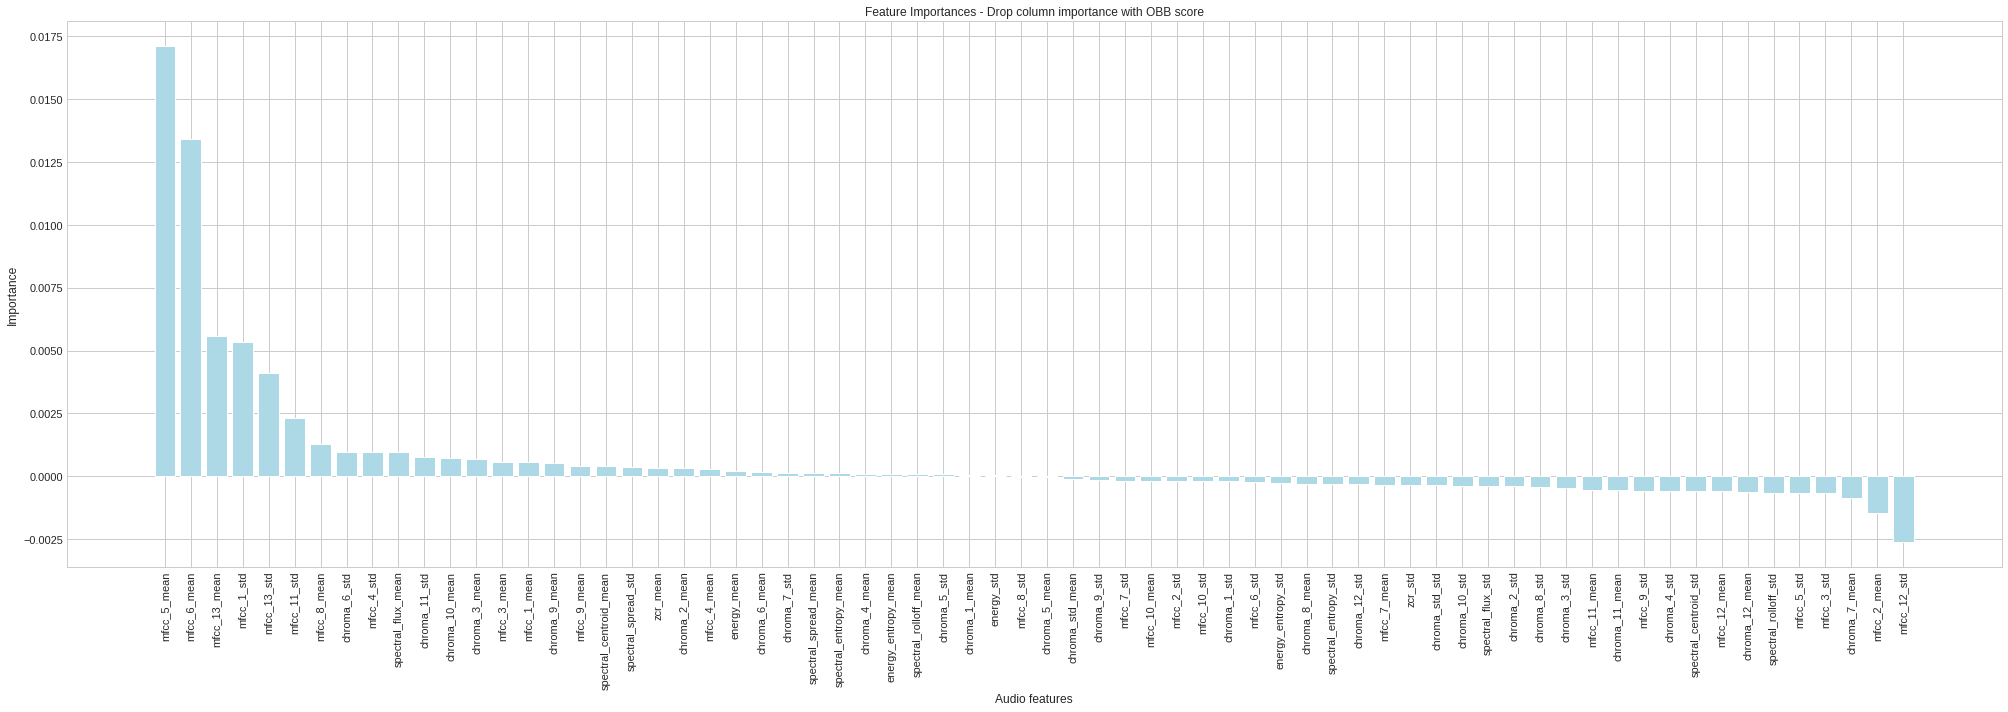

In [6]:
dfTmp = dfAll

"""The columns start time doesn't should be part of any model
Becase it is an information that can create an overfit and 
doesn't have any relation with the speaker's gender"""

num_features = [u'zcr_mean', u'energy_mean', u'energy_entropy_mean',
       u'spectral_centroid_mean', u'spectral_spread_mean',
       u'spectral_entropy_mean', u'spectral_flux_mean',
       u'spectral_rolloff_mean', u'mfcc_1_mean', u'mfcc_2_mean',
       u'mfcc_3_mean', u'mfcc_4_mean', u'mfcc_5_mean', u'mfcc_6_mean',
       u'mfcc_7_mean', u'mfcc_8_mean', u'mfcc_9_mean', u'mfcc_10_mean',
       u'mfcc_11_mean', u'mfcc_12_mean', u'mfcc_13_mean', u'chroma_1_mean',
       u'chroma_2_mean', u'chroma_3_mean', u'chroma_4_mean', u'chroma_5_mean',
       u'chroma_6_mean', u'chroma_7_mean', u'chroma_8_mean', u'chroma_9_mean',
       u'chroma_10_mean', u'chroma_11_mean', u'chroma_12_mean',
       u'chroma_std_mean', u'zcr_std', u'energy_std', u'energy_entropy_std',
       u'spectral_centroid_std', u'spectral_spread_std',
       u'spectral_entropy_std', u'spectral_flux_std', u'spectral_rolloff_std',
       u'mfcc_1_std', u'mfcc_2_std', u'mfcc_3_std', u'mfcc_4_std',
       u'mfcc_5_std', u'mfcc_6_std', u'mfcc_7_std', u'mfcc_8_std',
       u'mfcc_9_std', u'mfcc_10_std', u'mfcc_11_std', u'mfcc_12_std',
       u'mfcc_13_std', u'chroma_1_std', u'chroma_2_std', u'chroma_3_std',
       u'chroma_4_std', u'chroma_5_std', u'chroma_6_std', u'chroma_7_std',
       u'chroma_8_std', u'chroma_9_std', u'chroma_10_std', u'chroma_11_std',
       u'chroma_12_std', u'chroma_std_std']
target = 'result'

df = dfTmp[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop(target,axis=1), df_train[target]
X_test, y_test = df_test.drop(target,axis=1), df_test[target]

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

I = oob_dropcol_importances(rf, X_train, y_train)
plot_importance(I, "Audio features", yLabelText="Importance",
                title = 'Feature Importances - Drop column importance with OBB score')

I.reset_index(drop=False, inplace=True)

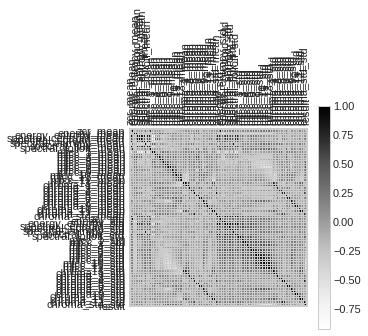

In [7]:
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns,rotation='vertical')
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

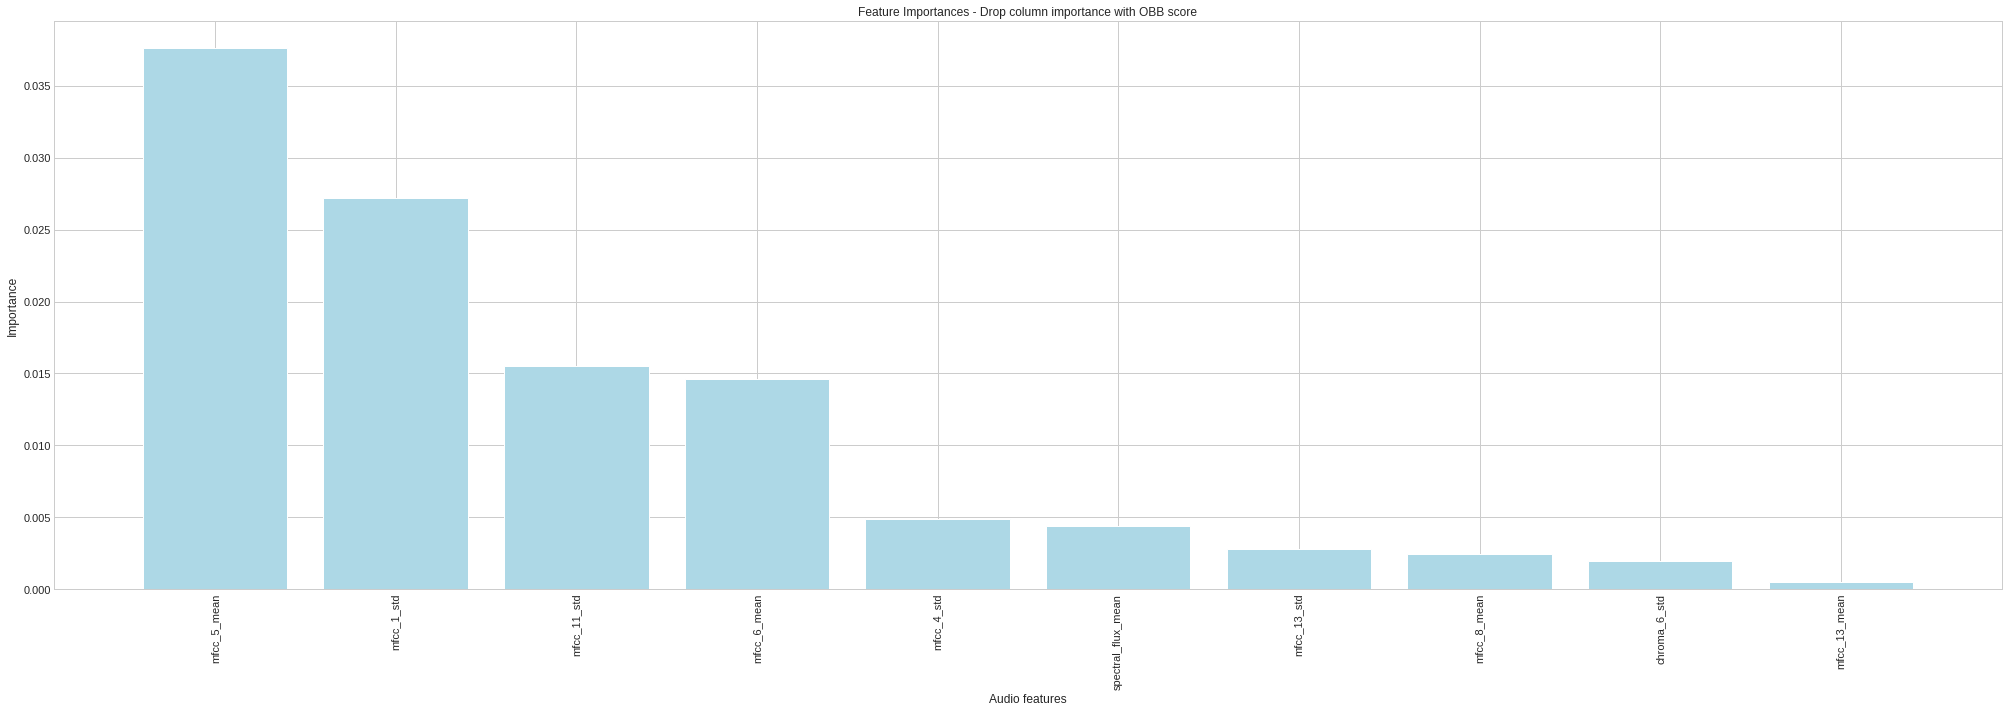

In [8]:
#Repeating the process for the first 10 features
num_features = list(I[u'Feature'].iloc[0:10].values)
target = 'result'

df = dfTmp[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop(target,axis=1), df_train[target]
X_test, y_test = df_test.drop(target,axis=1), df_test[target]

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

I2 = oob_dropcol_importances(rf, X_train, y_train)
plot_importance(I2, "Audio features", yLabelText="Importance",
                title = 'Feature Importances - Drop column importance with OBB score')

I2.reset_index(drop=False, inplace=True)



<Figure size 2880x1440 with 0 Axes>

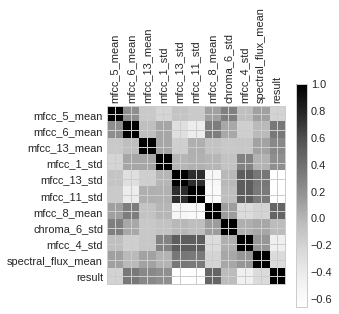

In [9]:
plt.figure(figsize = (40,20))

plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns,rotation='vertical')
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

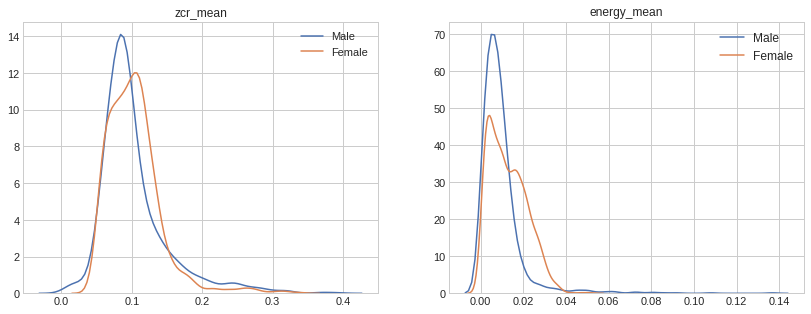

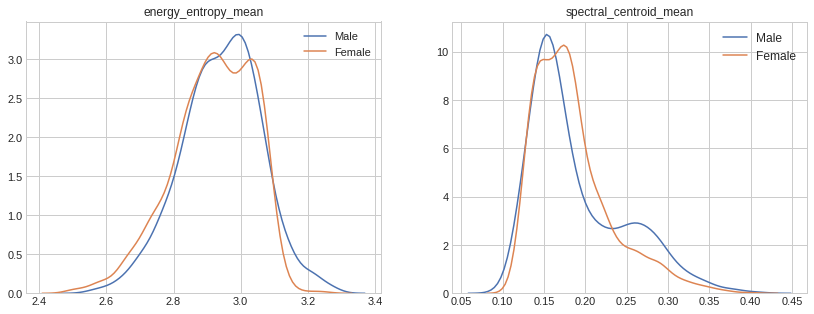

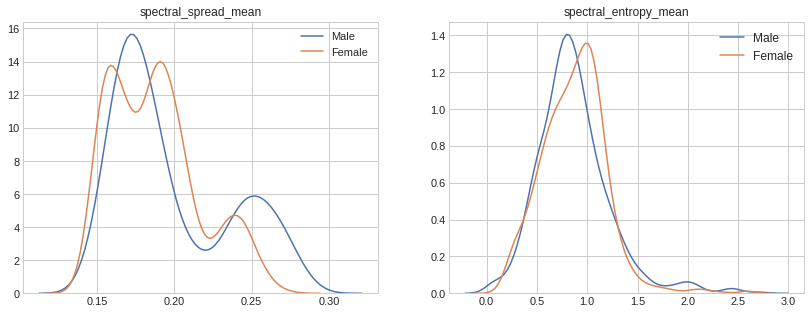

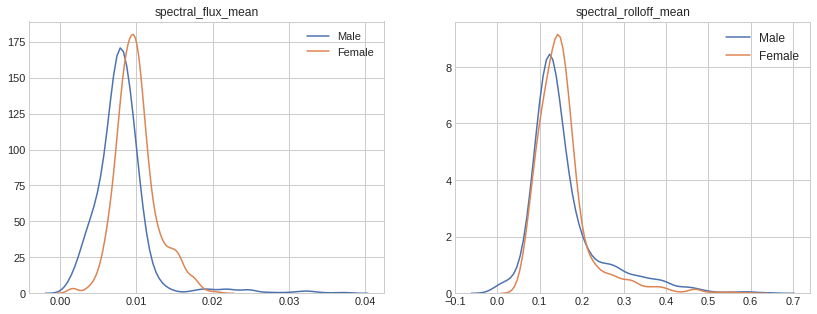

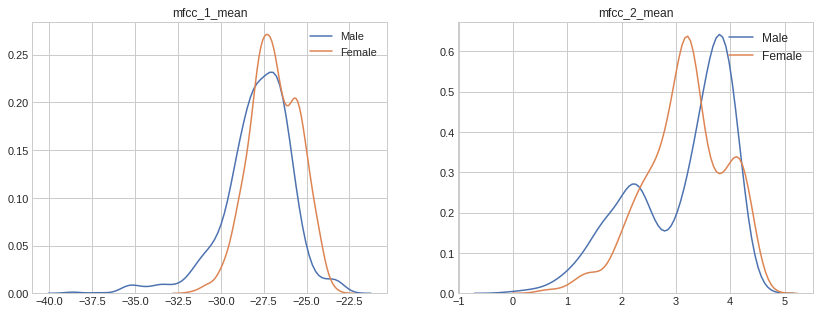

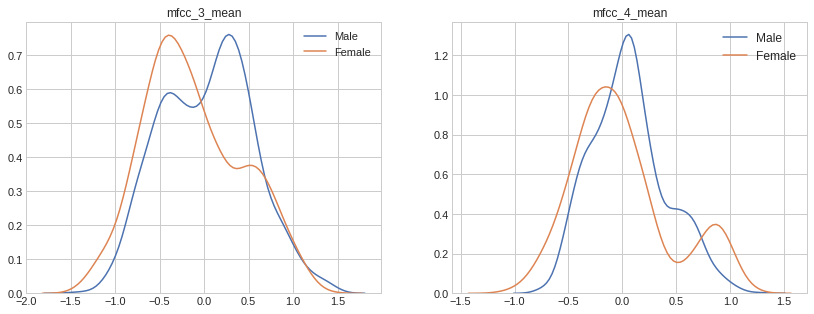

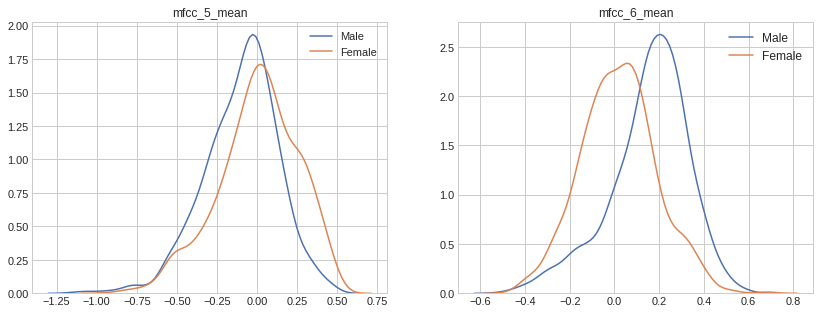

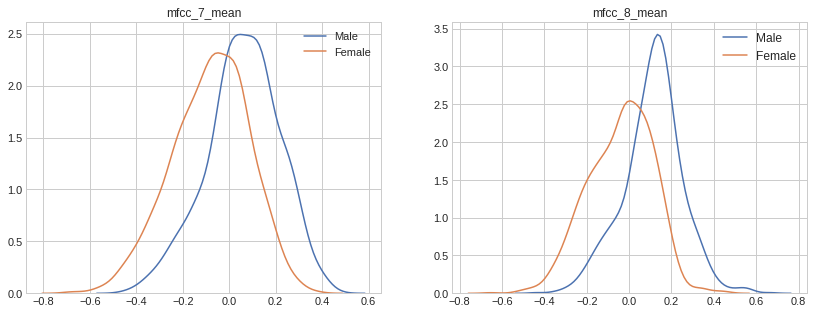

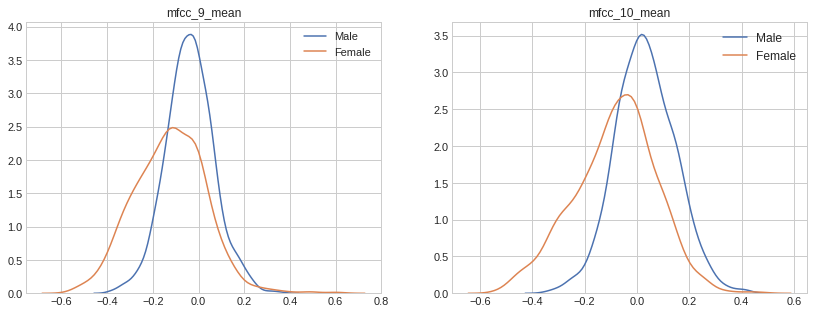

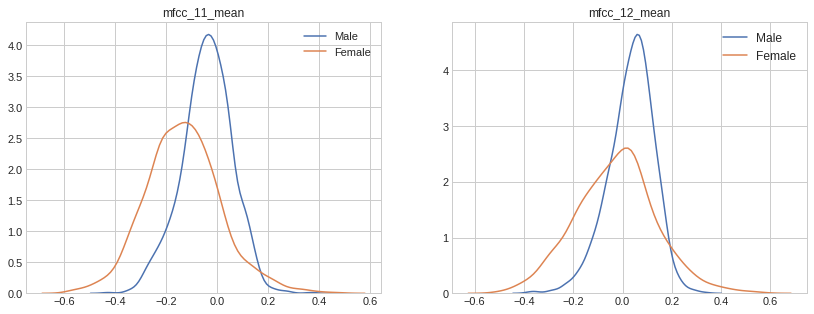

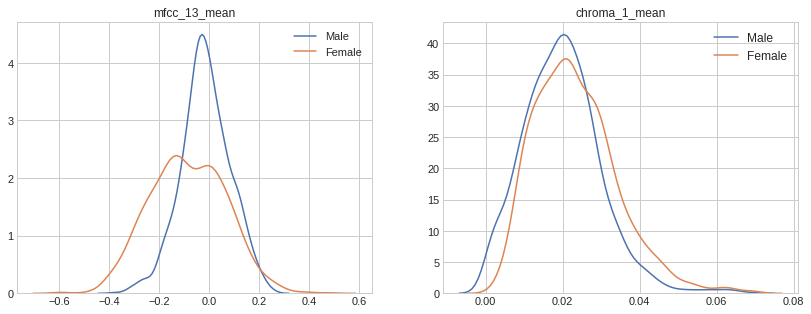

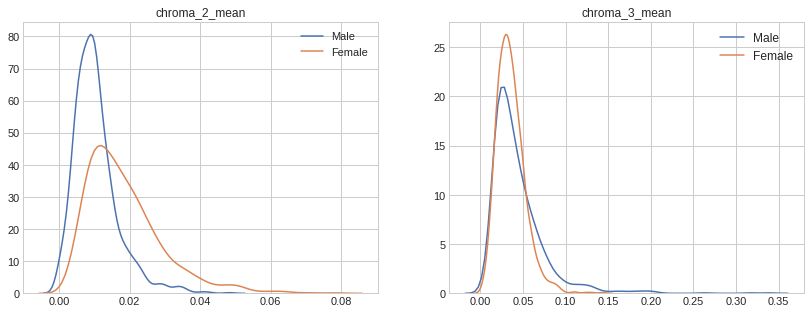

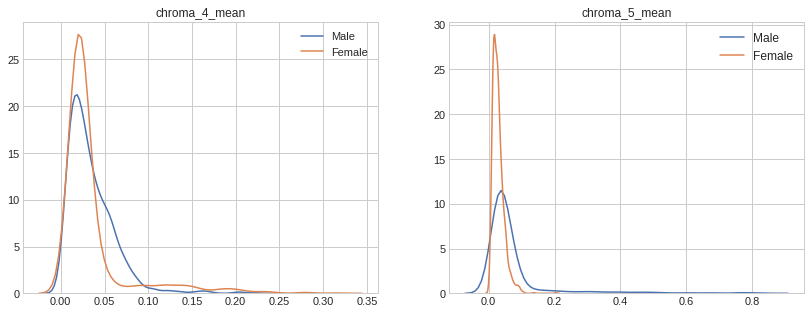

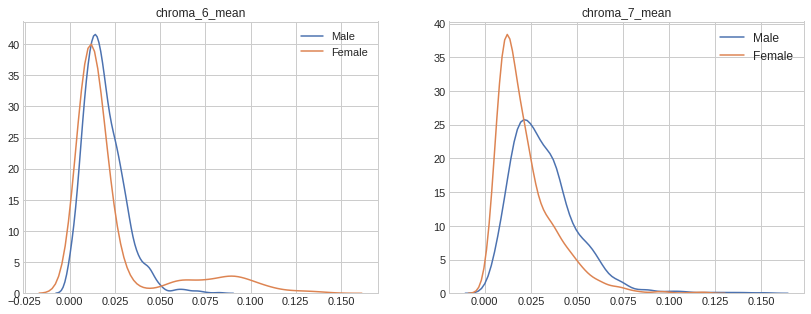

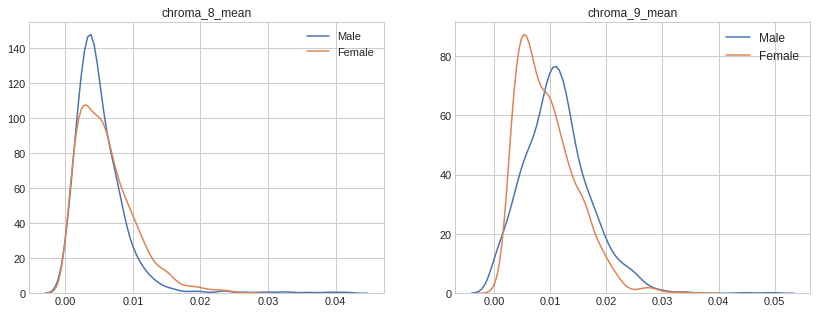

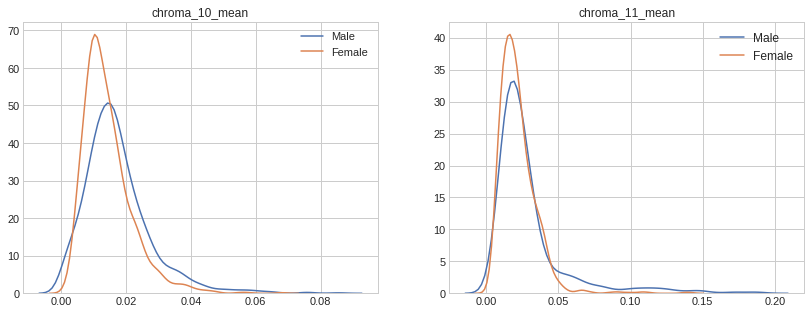

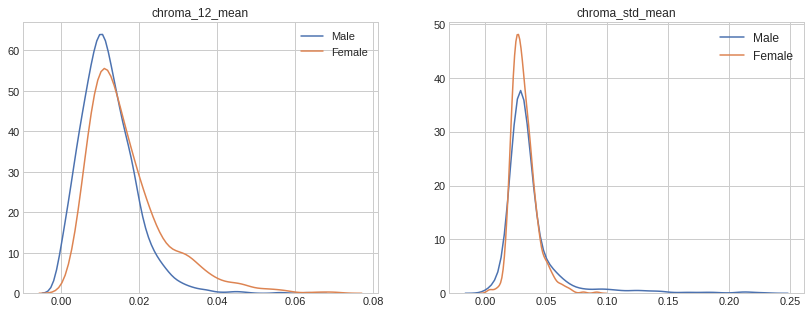

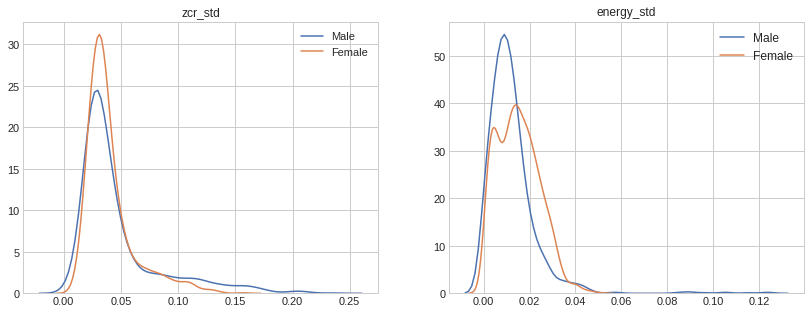

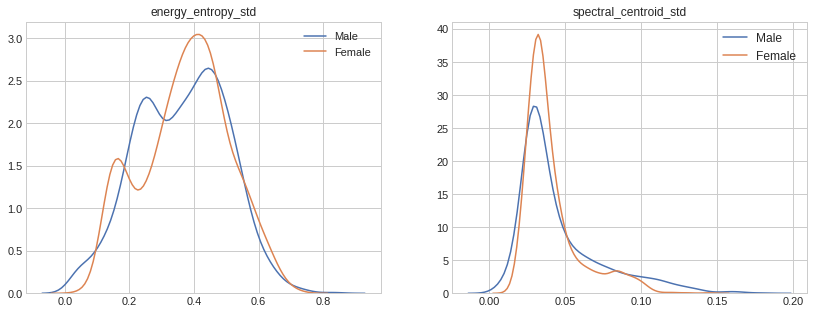

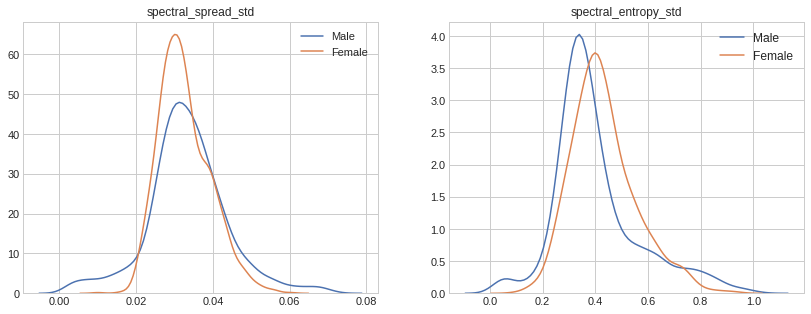

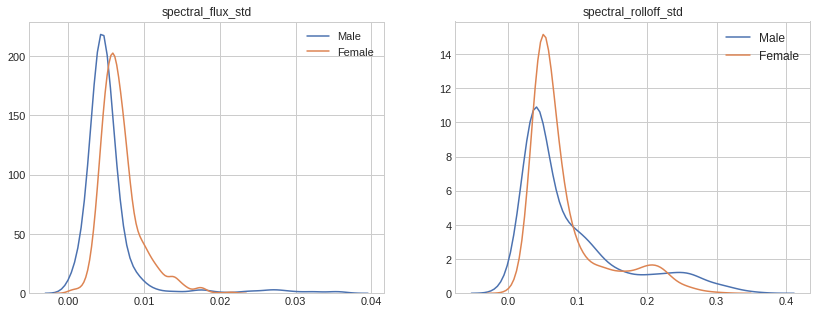

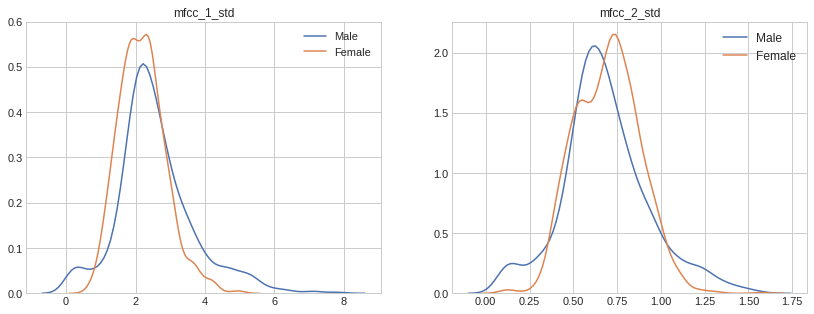

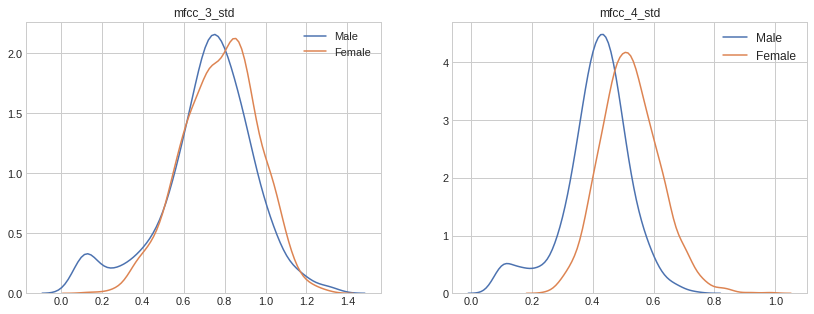

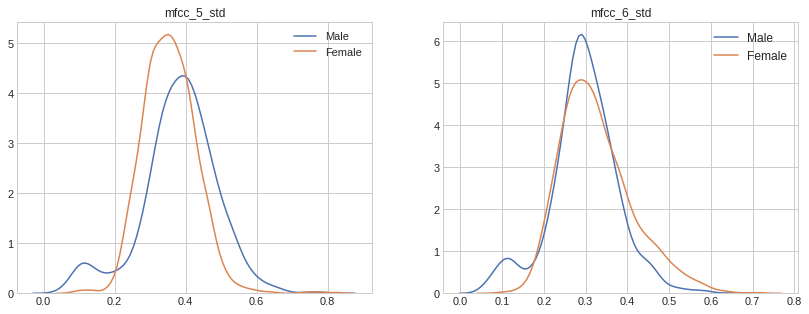

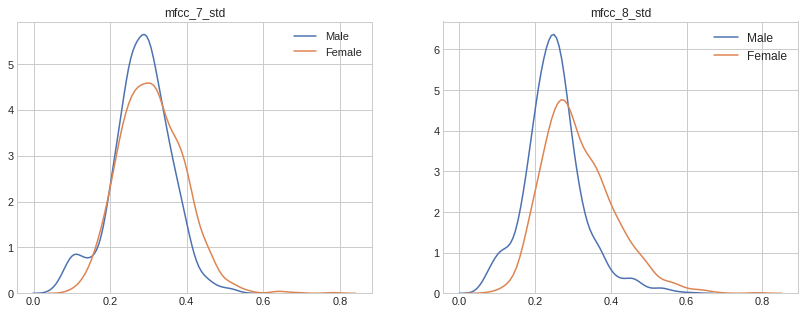

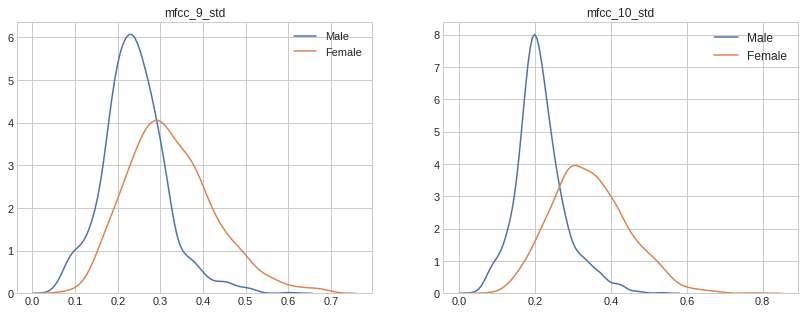

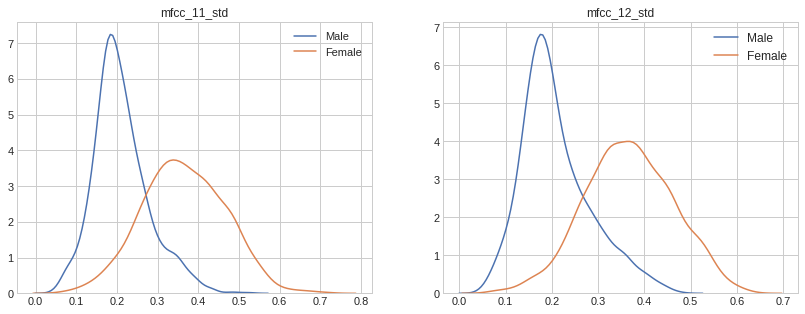

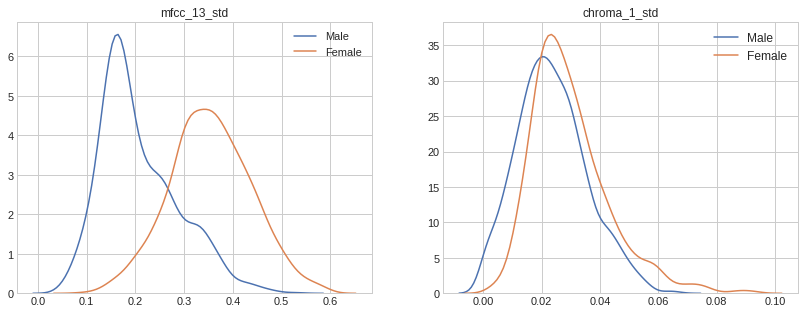

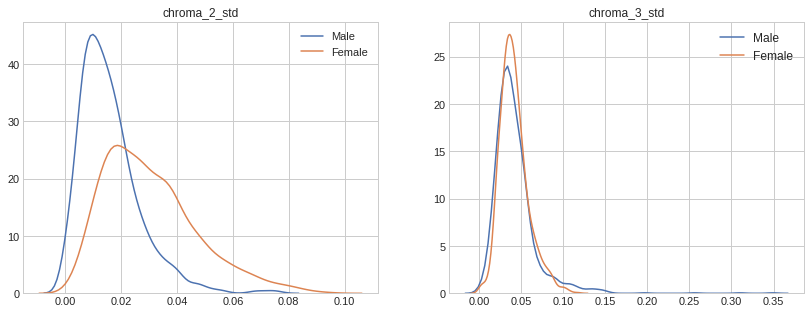

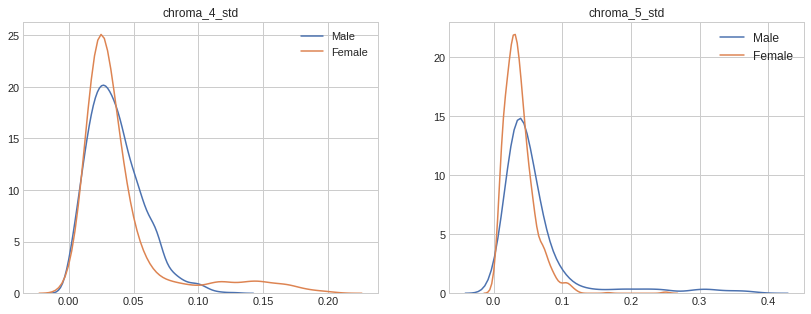

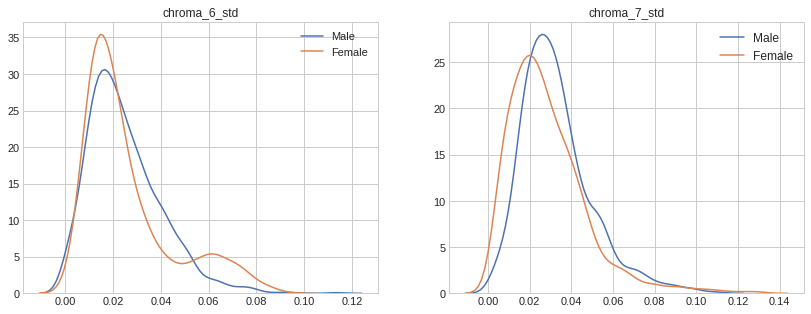

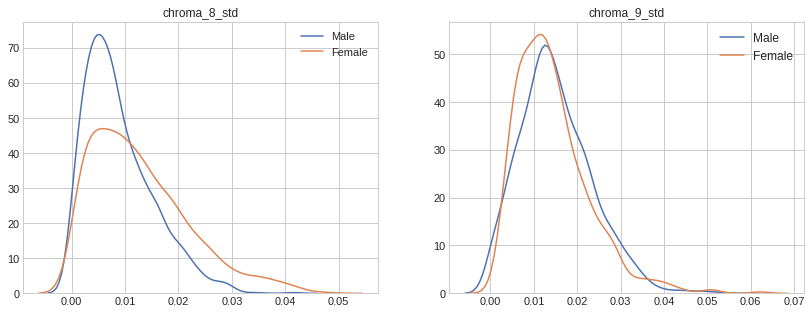

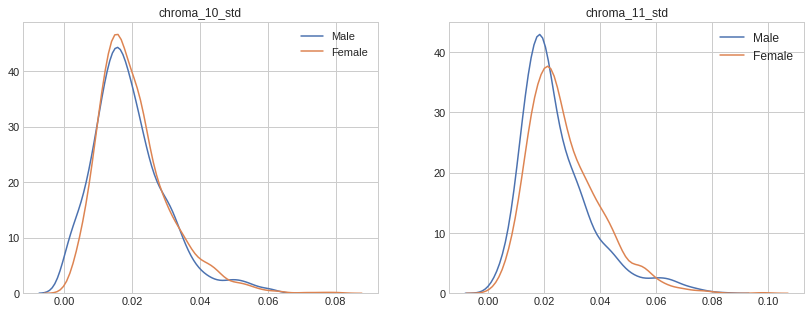

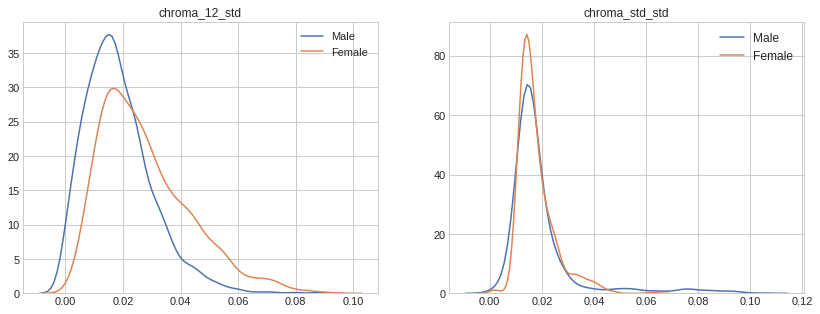

In [86]:
dfTmp = dfAll

#Checking the distribution of each feature for each class

num_features = [u'zcr_mean', u'energy_mean', u'energy_entropy_mean',
       u'spectral_centroid_mean', u'spectral_spread_mean',
       u'spectral_entropy_mean', u'spectral_flux_mean',
       u'spectral_rolloff_mean', u'mfcc_1_mean', u'mfcc_2_mean',
       u'mfcc_3_mean', u'mfcc_4_mean', u'mfcc_5_mean', u'mfcc_6_mean',
       u'mfcc_7_mean', u'mfcc_8_mean', u'mfcc_9_mean', u'mfcc_10_mean',
       u'mfcc_11_mean', u'mfcc_12_mean', u'mfcc_13_mean', u'chroma_1_mean',
       u'chroma_2_mean', u'chroma_3_mean', u'chroma_4_mean', u'chroma_5_mean',
       u'chroma_6_mean', u'chroma_7_mean', u'chroma_8_mean', u'chroma_9_mean',
       u'chroma_10_mean', u'chroma_11_mean', u'chroma_12_mean',
       u'chroma_std_mean', u'zcr_std', u'energy_std', u'energy_entropy_std',
       u'spectral_centroid_std', u'spectral_spread_std',
       u'spectral_entropy_std', u'spectral_flux_std', u'spectral_rolloff_std',
       u'mfcc_1_std', u'mfcc_2_std', u'mfcc_3_std', u'mfcc_4_std',
       u'mfcc_5_std', u'mfcc_6_std', u'mfcc_7_std', u'mfcc_8_std',
       u'mfcc_9_std', u'mfcc_10_std', u'mfcc_11_std', u'mfcc_12_std',
       u'mfcc_13_std', u'chroma_1_std', u'chroma_2_std', u'chroma_3_std',
       u'chroma_4_std', u'chroma_5_std', u'chroma_6_std', u'chroma_7_std',
       u'chroma_8_std', u'chroma_9_std', u'chroma_10_std', u'chroma_11_std',
       u'chroma_12_std', u'chroma_std_std', u'Agent']
target = 'result'

df = dfTmp[num_features + [target]]



num_features.remove(u'Agent')
for column0, column1 in zip(num_features[0::2], num_features[1::2]):

    y0 = df[df['result'] == 0 ][column0].values
    x0 = df[df['result'] == 1 ][column0].values
    y1 = df[df['result'] == 0 ][column1].values
    x1 = df[df['result'] == 1 ][column1].values
    
    #Making sure that the size of each class is equals on this plot
    np.random.shuffle(y0)
    np.random.shuffle(x0)
    np.random.shuffle(y1)
    np.random.shuffle(x1)
    minSize = min(len(y0),len(x0))                  
    y0 = y0[0:minSize]
    x0 = x0[0:minSize]
    minSize = min(len(y1),len(x1)) 
    y1 = y1[0:minSize]
    x1 = x1[0:minSize]
    
    fig = plt.figure(figsize=(14, 5))
    ax = plt.subplot("121")
    ax.set_title(column0)
    ax.legend(loc='upper right',prop={'size': 12})
    sns.distplot(x0,hist = False, kde = True, label='Male')
    sns.distplot(y0,hist = False, kde = True, label='Female')
    
    ax = plt.subplot("122")
    ax.set_title(column1)
    sns.distplot(x1,hist = False, kde = True, label='Male')
    sns.distplot(y1,hist = False, kde = True, label='Female')
    ax.legend(loc='upper right',prop={'size': 12})

    plt.show()


O objetivo do plot anterior é tentar aumentar a eficiencia do método OOB utilizado anteriormente, removendo as features que não conseguem separar bem as classes. Nesse caso irei remover as features:

* Chroma_std_std
* chroma_10_std
* Chroma_3_Std
* Chroma_6_mean
* Energy_entropy_mean


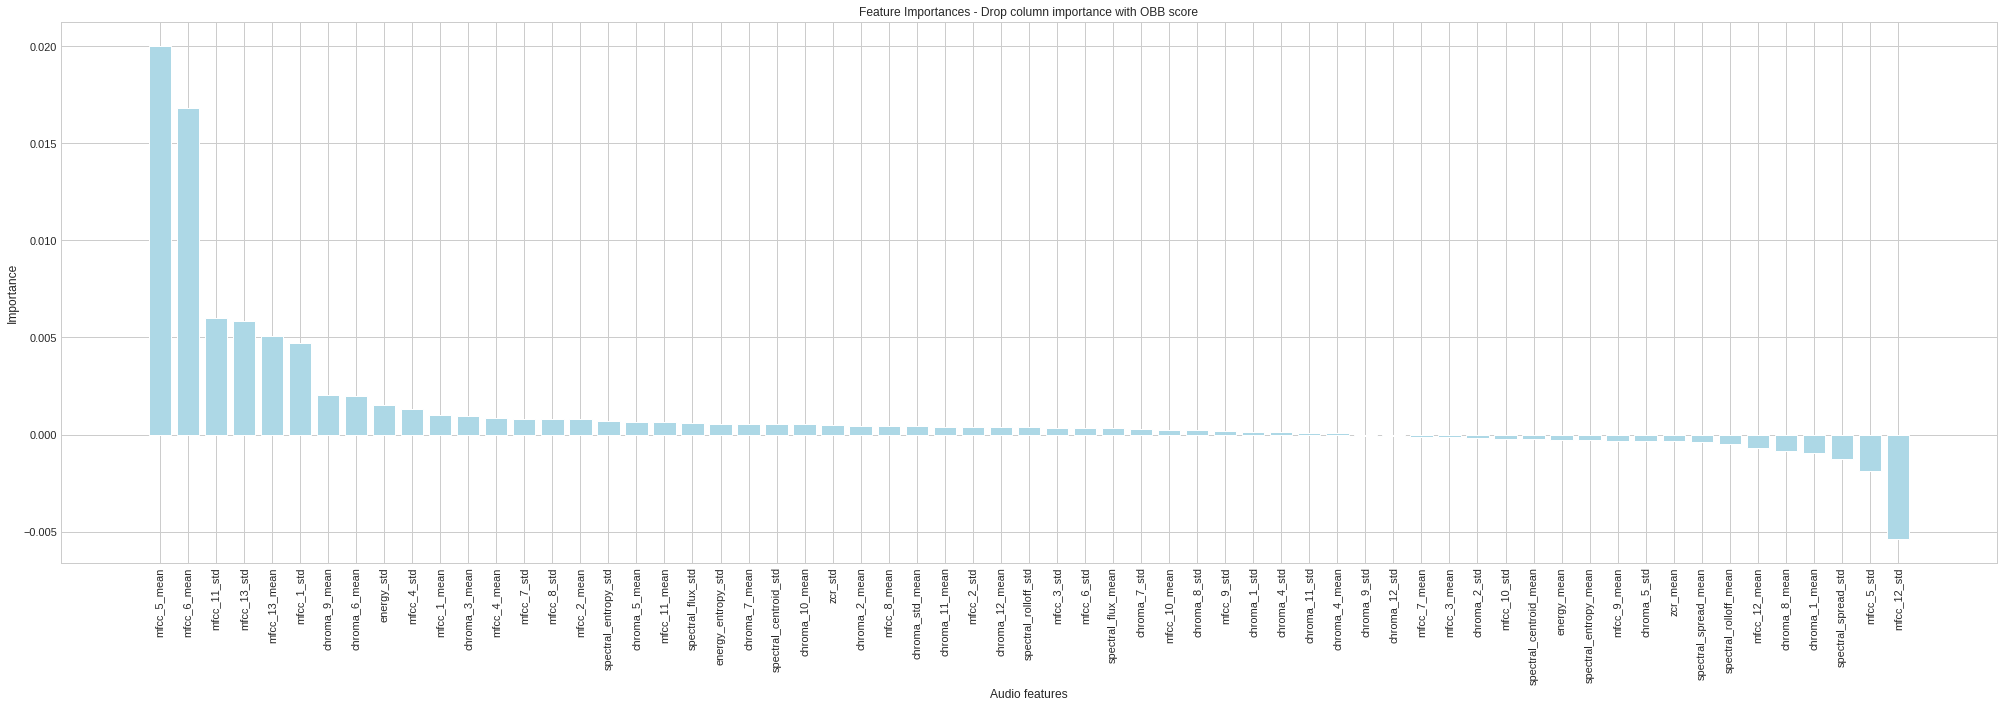

In [87]:
dfTmp = dfAll

"""The columns start time doesn't should be part of any model
Becase it is an information that can create an overfit and 
doesn't have any relation with the speaker's gender"""

num_features = [u'zcr_mean', u'energy_mean', 
       u'spectral_centroid_mean', u'spectral_spread_mean',
       u'spectral_entropy_mean', u'spectral_flux_mean',
       u'spectral_rolloff_mean', u'mfcc_1_mean', u'mfcc_2_mean',
       u'mfcc_3_mean', u'mfcc_4_mean', u'mfcc_5_mean', u'mfcc_6_mean',
       u'mfcc_7_mean', u'mfcc_8_mean', u'mfcc_9_mean', u'mfcc_10_mean',
       u'mfcc_11_mean', u'mfcc_12_mean', u'mfcc_13_mean', u'chroma_1_mean',
       u'chroma_2_mean', u'chroma_3_mean', u'chroma_4_mean', u'chroma_5_mean',
       u'chroma_6_mean', u'chroma_7_mean', u'chroma_8_mean', u'chroma_9_mean',
       u'chroma_10_mean', u'chroma_11_mean', u'chroma_12_mean',
       u'chroma_std_mean', u'zcr_std', u'energy_std', u'energy_entropy_std',
       u'spectral_centroid_std', u'spectral_spread_std',
       u'spectral_entropy_std', u'spectral_flux_std', u'spectral_rolloff_std',
       u'mfcc_1_std', u'mfcc_2_std', u'mfcc_3_std', u'mfcc_4_std',
       u'mfcc_5_std', u'mfcc_6_std', u'mfcc_7_std', u'mfcc_8_std',
       u'mfcc_9_std', u'mfcc_10_std', u'mfcc_11_std', u'mfcc_12_std',
       u'mfcc_13_std', u'chroma_1_std', u'chroma_2_std',
       u'chroma_4_std', u'chroma_5_std', u'chroma_7_std',
       u'chroma_8_std', u'chroma_9_std', u'chroma_11_std',
       u'chroma_12_std']
target = 'result'

df = dfTmp[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop(target,axis=1), df_train[target]
X_test, y_test = df_test.drop(target,axis=1), df_test[target]

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

I3 = oob_dropcol_importances(rf, X_train, y_train)
plot_importance(I3, "Audio features", yLabelText="Importance",
                title = 'Feature Importances - Drop column importance with OBB score')

I3.reset_index(drop=False, inplace=True)

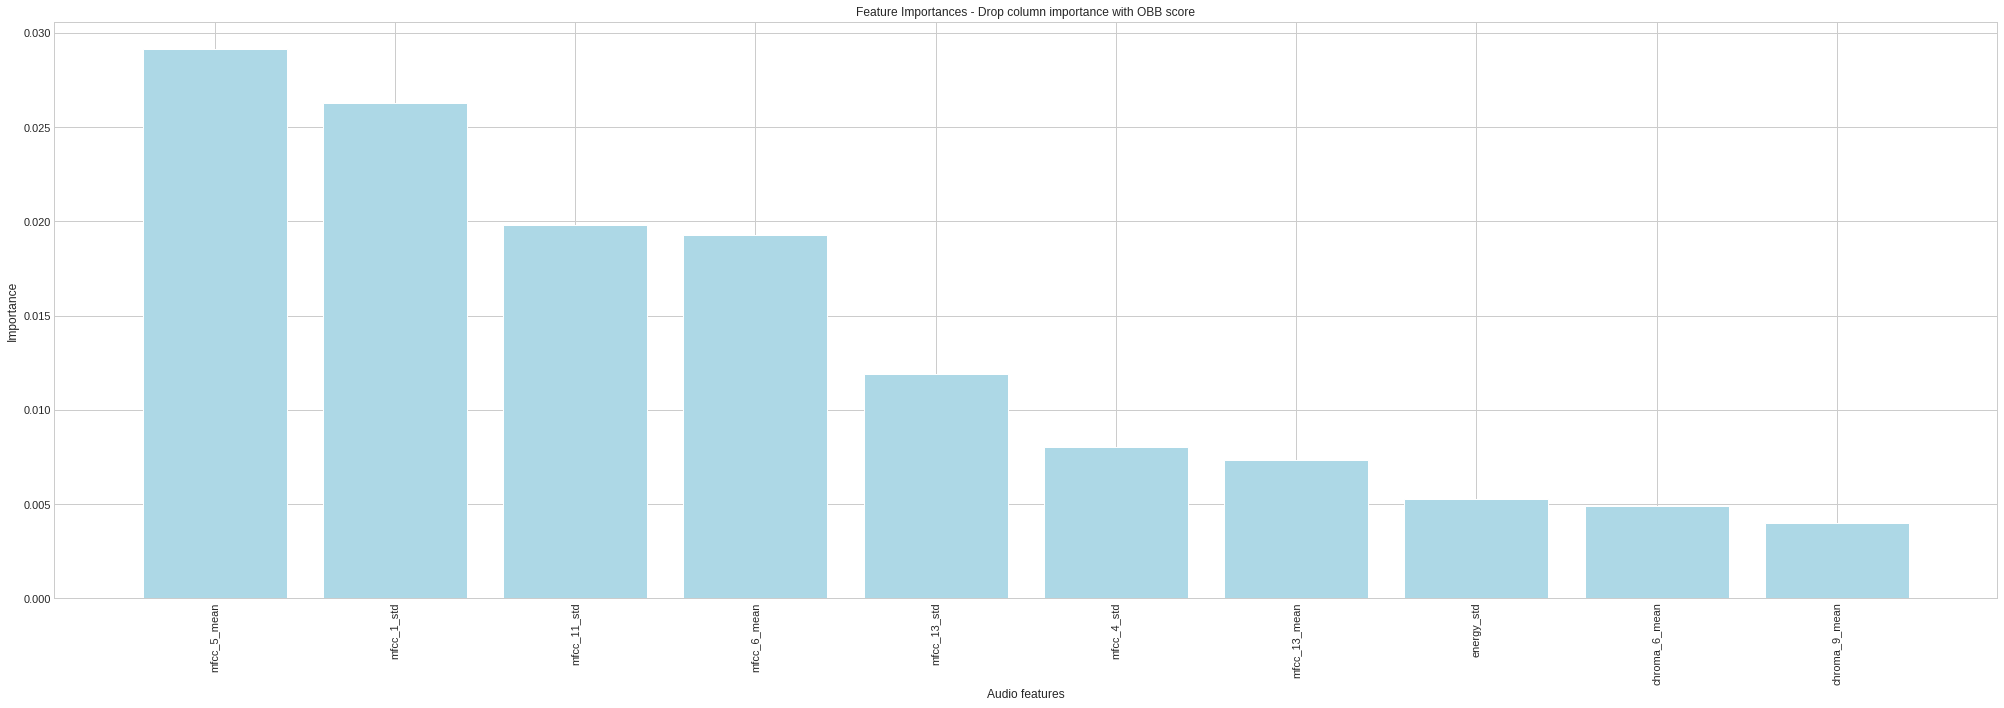

In [88]:
#Repeating the process for the first 10 features
num_features = list(I3[u'Feature'].iloc[0:10].values)
target = 'result'

df = dfTmp[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop(target,axis=1), df_train[target]
X_test, y_test = df_test.drop(target,axis=1), df_test[target]

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

I4 = oob_dropcol_importances(rf, X_train, y_train)
plot_importance(I4, "Audio features", yLabelText="Importance",
                title = 'Feature Importances - Drop column importance with OBB score')

I4.reset_index(drop=False, inplace=True)


(array([ 29., 437., 627., 169.,  77.,  30.,  28.,  10.,   5.,   3.]),
 array([0.00230551, 0.04134416, 0.0803828 , 0.11942144, 0.15846009,
        0.19749873, 0.23653738, 0.27557602, 0.31461466, 0.35365331,
        0.39269195]),
 <a list of 10 Patch objects>)